In [1]:
import pandas as pd
import numpy as np
#text preprocessing
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.models import LdaSeqModel
from gensim.models import LdaModel,LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
PYTHONHASHSEED=0 #Disable randomization

In [2]:
df = pd.read_csv("tweets&sentiment&absoluteprices.csv", index_col = 0)
req = df.loc[:,['cleaned_text','created_at']]
req = req.dropna()
req.head()

,cleaned_text,created_at
source,,
Twitter for iPhone,thank,2020-09-30 23:45:25
Twitter for iPhone,big news maine court side rnc uphold ban ballo...,2020-09-30 23:25:31
Twitter for iPhone,thank paul,2020-09-30 23:00:33
Twitter for iPhone,defective ballot new york want replace happen ...,2020-09-30 22:59:02
Twitter for iPhone,half years secure americas border rebuild awes...,2020-09-30 22:51:05


In [3]:
#See time slice quantity
print(df.loc[df['created_at']>='2020-01-01'].shape)
print(df.loc[(df['created_at']<'2020-01-01') & (df['created_at']>='2019-01-01')].shape)
print(df.loc[(df['created_at']<'2019-01-01') & (df['created_at']>='2018-01-01')].shape)
print(df.loc[(df['created_at']<'2018-01-01') & (df['created_at']>='2017-01-01')].shape)
print(df.loc[(df['created_at']<'2017-01-01') & (df['created_at']>='2016-01-01')].shape)

(9249, 27)
(7835, 27)
(3572, 27)
(2602, 27)
(4223, 27)


### Pre-process for gensim 
^ Obtained from https://radimrehurek.com/gensim_4.0.0/auto_examples/tutorials/run_lda.html

In [4]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
docs = df.cleaned_text.dropna()
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

from gensim.models import Phrases

# Add bigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

Number of unique tokens: 4090
Number of documents: 26289


In [31]:
lis = []
#keeping num of topics fixed, gridsearch
decay = [0.5,0.7,0.9]
passes = [100,200,300]
chunksize=[300,600,900]

for d in decay:
    for p in passes:
        for c in chunksize:
            model = LdaModel(
                corpus=corpus,
                id2word=id2word,
                chunksize=c,
                alpha='auto',
                eta='auto',
                decay=d,
                iterations=300,
                num_topics=10,
                passes=p,
                eval_every=None,
                random_state = 4222)
            cm = CoherenceModel(model, corpus=corpus, texts = docs,dictionary=dictionary,coherence='c_v')
            score = cm.get_coherence()
            lis.append([d,p,c,score])
            print(str('decay: %.2f, passes %d, chunksize: %d, coherence score: %.3f'%(d,p,c,score)))

decay: 0.50, passes 100, chunksize: 300, coherence score: 0.307
decay: 0.50, passes 100, chunksize: 600, coherence score: 0.350
decay: 0.50, passes 100, chunksize: 900, coherence score: 0.347
decay: 0.50, passes 200, chunksize: 300, coherence score: 0.318
decay: 0.50, passes 200, chunksize: 600, coherence score: 0.347
decay: 0.50, passes 200, chunksize: 900, coherence score: 0.353
decay: 0.50, passes 300, chunksize: 300, coherence score: 0.320
decay: 0.50, passes 300, chunksize: 600, coherence score: 0.353
decay: 0.50, passes 300, chunksize: 900, coherence score: 0.351
decay: 0.70, passes 100, chunksize: 300, coherence score: 0.336
decay: 0.70, passes 100, chunksize: 600, coherence score: 0.375
decay: 0.70, passes 100, chunksize: 900, coherence score: 0.364
decay: 0.70, passes 200, chunksize: 300, coherence score: 0.342
decay: 0.70, passes 200, chunksize: 600, coherence score: 0.373
decay: 0.70, passes 200, chunksize: 900, coherence score: 0.363
decay: 0.70, passes 300, chunksize: 300,

Best is decay: 0.90, passes 300, chunksize: 900, coherence score: 0.387

##### Now we have an idea of the optimal hyperparameter.

We enable randomness to use paralellization and find an optimal model based on:

1. Coherence score
2. Predicted topics uniformness (Use Kullback-Leibler divergence to evaluate)

In [5]:
#Enable randomness
import random
PYTHONHASHSEED = random

In [16]:
#Enable randomness
import random
PYTHONHASHSEED = random

models = []

#Uniform distribution
from scipy.stats import entropy
unif = np.full(10,0.1)

# Just compare 10 random models at 300 iterations
for i in range(10):
    model = LdaMulticore(
        workers = 7,
        corpus=corpus,
        id2word=id2word,
        chunksize=900,
        alpha='asymmetric',
        eta='auto',
        decay=0.9,
        iterations=300,
        num_topics=10,
        passes=300,
        eval_every=None,
        random_state = 4222)
    cm = CoherenceModel(model, corpus=corpus, texts = docs,dictionary=dictionary,coherence='c_v')
    score = cm.get_coherence()
    
    from copy import deepcopy
    df2 = deepcopy(df).dropna()
    topic = []
    texts = df2.cleaned_text
    for j in range(len(texts)):
        bow = dictionary.doc2bow(tokenizer.tokenize(texts[j]))
        pred = model.get_document_topics(bow,minimum_probability=0)
        pred.sort(key = lambda x: x[1],reverse = True)
        topic.append(pred[0][0] + 1)
        
    topic_prob = pd.DataFrame(topic).value_counts()/len(topic)
    divergence = entropy(unif,topic_prob)
    models.append([model,score,divergence])
    print("model %d: score: %.4f, entropy: %.4f"%(i+1,score,divergence))

model 1: score: 0.4072, entropy: 0.1485
model 2: score: 0.4141, entropy: 0.1512
model 3: score: 0.4115, entropy: 0.2079
model 4: score: 0.4177, entropy: 0.1375
model 5: score: 0.4048, entropy: 0.1651
model 6: score: 0.4168, entropy: 0.1495
model 7: score: 0.4175, entropy: 0.1371
model 8: score: 0.4229, entropy: 0.1387
model 9: score: 0.4221, entropy: 0.1740
model 10: score: 0.4107, entropy: 0.1349


#### From above, we use model 10 with the lowest entropy.

In [55]:
df2 = deepcopy(df).dropna()
topic = []
texts = df2.cleaned_text
for i in range(len(texts)):
    bow = dictionary.doc2bow(tokenizer.tokenize(texts[i]))
    pred = models[9][0].get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    topic.append(pred[0][0] + 1)

In [54]:
#Save models
#import os
#filepath = os.getcwd() + "\\Coherence models"
#for i in range(10):
#    models[i][0].save(filepath+"\\model " + str(i+1))

In [ ]:
#Load models
#models = []
#import os
#filepath = os.getcwd() + "\\Coherence models"
#for i in range(10):
#    models.append(LdaModel.load(filepath+"\\model " + str(i+1))

In [58]:
'''
for i in range(len(models)):
    bow = dictionary.doc2bow(tokenizer.tokenize("won election lot"))
    pred = model.get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    print("model %d prediction: %d"%(i+1,pred[0][0]+1))
'''

model 1 prediction: 4
model 2 prediction: 8
model 3 prediction: 4
model 4 prediction: 4
model 5 prediction: 4
model 6 prediction: 8
model 7 prediction: 4
model 8 prediction: 4
model 9 prediction: 4
model 10 prediction: 4


#### Attach topics

In [59]:
used_model = models[9][0]

df2 = deepcopy(df).dropna()
topic = []
texts = df2.cleaned_text
for i in range(len(texts)):
    bow = dictionary.doc2bow(tokenizer.tokenize(texts[i]))
    pred = used_model.get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    topic.append(pred[0][0] + 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA76EA5988>]],
      dtype=object)

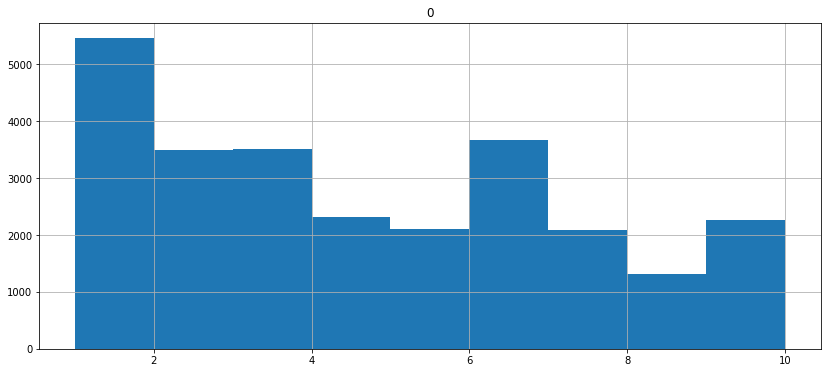

In [60]:
pd.DataFrame(topic).hist(bins=bins,figsize=[14,6])

In [68]:
df2 = pd.read_csv("tweets&sentiment&absoluteprices.csv", index_col = 0)
df2 = df2.dropna()
df2.reset_index(inplace =True)
df2

,source,text,cleaned_text,created_at,retweet_count,favorite_count,is_retweet,id_str,hashtag,mention,...,neu_sentiment,pos_sentiment,compound_sentiment,created_date,created_time,passed_closing,market_date,^GSPC,^IXIC,VGT
0,Twitter for iPhone,Thank you @HerschelWalker! https://t.co/XjlYe8...,thank,2020-09-30 23:45:25,19616,65721,False,1311512518800470016,[],['@HerschelWalker'],...,0.000,1.000,0.4199,2020-09-30,23:45:25,1,2020-10-01,3380.800049,11326.509766,315.329987
1,Twitter for iPhone,RT @GOPChairwoman: Big news!A Maine court side...,big news maine court side rnc uphold ban ballo...,2020-09-30 23:25:31,29393,0,True,1311507509958471680,[],[],...,1.000,0.000,0.0000,2020-09-30,23:25:31,1,2020-10-01,3380.800049,11326.509766,315.329987
2,Twitter for iPhone,Thank you Paul! https://t.co/aAk1sfww0d,thank paul,2020-09-30 23:00:33,15992,63294,False,1311501225423073281,[],[],...,0.264,0.736,0.4199,2020-09-30,23:00:33,1,2020-10-01,3380.800049,11326.509766,315.329987
3,Twitter for iPhone,100000 DEFECTIVE BALLOTS IN NEW YORK. THEY WAN...,defective ballot new york want replace happen ...,2020-09-30 22:59:02,51445,190750,False,1311500843309387781,[],[],...,0.796,0.028,-0.7988,2020-09-30,22:59:02,1,2020-10-01,3380.800049,11326.509766,315.329987
4,Twitter for iPhone,In just 3 and a half years we have secured Ame...,half years secure americas border rebuild awes...,2020-09-30 22:51:05,18885,70838,False,1311498845860196355,['#MAGA'],[],...,0.610,0.188,-0.1260,2020-09-30,22:51:05,1,2020-10-01,3380.800049,11326.509766,315.329987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26226,Twitter for Android,Well the year has officially begun. I have man...,well year officially begin many stop plan work...,2016-01-01 18:00:09,2642,8495,False,683060169677344768,[],[],...,0.495,0.340,0.6360,2016-01-01,18:00:09,1,2016-01-04,2012.660034,4903.089844,100.618843
26227,Twitter for Android,"""@sprinklermanus: @CNN @realDonaldTrump they'r...",spend millions still go win go donald trump,2016-01-01 16:29:56,933,3330,False,683037464504745985,[],"['@sprinklermanus', '@CNN', '@realDonaldTrump']",...,0.743,0.257,0.5859,2016-01-01,16:29:56,1,2016-01-04,2012.660034,4903.089844,100.618843
26228,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",hillary say fog war explanation lie benghazi n...,2016-01-01 01:08:06,2721,7490,False,682805477168779264,[],['@jallenaip'],...,0.620,0.000,-0.8478,2016-01-01,01:08:06,0,2016-01-04,2012.660034,4903.089844,100.618843
26229,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,happy new year maralago thank great family sup...,2016-01-01 01:07:28,1948,8258,False,682805320217980929,['#MarALago'],[],...,0.231,0.769,0.9230,2016-01-01,01:07:28,0,2016-01-04,2012.660034,4903.089844,100.618843


In [70]:
df2.columns

Index(['source', 'text', 'cleaned_text', 'created_at', 'retweet_count',
       'favorite_count', 'is_retweet', 'id_str', 'hashtag', 'mention',
       'hashtag_count', 'mention_count', 'word_count', 'char_count',
       'word_density', 'punctuation_freq', 'upper_case_freq', 'neg_sentiment',
       'neu_sentiment', 'pos_sentiment', 'compound_sentiment', 'created_date',
       'created_time', 'passed_closing', 'market_date', '^GSPC', '^IXIC',
       'VGT', 'topic'],
      dtype='object')

In [89]:
df2['topic'] = np.asarray(topic)

#Melt dataframe down by date and topic

#Get frequency of topic per day
freq = df2.groupby(['market_date','topic']).agg(['count'])['text']

#Get average of various features that make sense by daily aggregation
var = df2.groupby(['market_date','topic']).agg('mean')[['retweet_count','favorite_count','hashtag_count','mention_count',
                                                          'word_count','word_density','punctuation_freq','upper_case_freq','char_count',
                                                          'pos_sentiment','neu_sentiment','neg_sentiment','compound_sentiment',
                                                         'passed_closing']]

#Add in frequency
var['freq'] = freq

daily = var.unstack().pipe(lambda x: x.set_axis([f'{a}_{b}' for a, b in x.columns], axis=1, inplace=False))
cols = daily.columns #Preserve column names
rows = df2['market_date'].unique()
rows.sort()

daily = pd.DataFrame(np.nan_to_num(np.asarray(daily)))
daily.columns=cols
daily.index = rows
daily

,retweet_count_1,retweet_count_2,retweet_count_3,retweet_count_4,retweet_count_5,retweet_count_6,retweet_count_7,retweet_count_8,retweet_count_9,retweet_count_10,...,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10
2016-01-04,1985.357143,7542.333333,2248.00,2714.571429,6065.000000,2062.666667,1539.500000,2324.5,1449.333333,4195.000000,...,14.0,3.0,9.0,7.0,1.0,3.0,2.0,2.0,3.0,2.0
2016-01-05,1286.000000,1159.000000,1049.00,1092.000000,0.000000,1571.000000,932.000000,0.0,1325.750000,0.000000,...,3.0,1.0,1.0,1.0,0.0,4.0,1.0,0.0,4.0,0.0
2016-01-06,2096.250000,800.000000,3134.20,1237.000000,2517.000000,2341.000000,0.000000,0.0,724.000000,0.000000,...,4.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0
2016-01-07,1471.000000,0.000000,6813.50,1726.500000,1393.000000,1588.500000,0.000000,0.0,1114.500000,2026.000000,...,1.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,2.0,1.0
2016-01-08,2246.333333,0.000000,1014.00,1548.000000,1425.000000,1688.666667,0.000000,1968.0,0.000000,0.000000,...,3.0,0.0,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-25,13841.125000,7468.823529,9028.75,11875.416667,17963.909091,13305.666667,5581.083333,13394.0,17808.250000,5749.500000,...,8.0,17.0,8.0,12.0,11.0,3.0,12.0,4.0,4.0,2.0
2020-09-28,14742.000000,9792.750000,26678.20,25413.666667,19582.333333,29004.500000,8355.521739,20924.0,19850.000000,30891.555556,...,10.0,4.0,5.0,6.0,3.0,6.0,23.0,6.0,1.0,9.0
2020-09-29,19296.200000,6911.500000,8287.00,15762.000000,32283.500000,36918.500000,0.000000,13933.2,22894.000000,17406.666667,...,5.0,2.0,1.0,2.0,2.0,2.0,0.0,5.0,1.0,3.0
2020-09-30,20460.000000,14327.750000,24470.75,13862.222222,20833.272727,17549.750000,32909.000000,16050.0,13780.142857,9885.600000,...,1.0,8.0,4.0,9.0,11.0,4.0,1.0,3.0,7.0,10.0


##### Add in Ticker values

In [123]:
tickers = df2.set_index('market_date')[['^GSPC','^IXIC','VGT']]
tickers2 = []
temp_set = []
for i in range(len(tickers)):
    if tickers.index[i] not in temp_set:
        temp_set.append(tickers.index[i])
        tickers2.append(tickers.iloc[i].values)
        
tickers2[:5]

[array([ 3380.80004883, 11326.50976562,   315.32998657]),
 array([ 3363.        , 11167.50976562,   311.45001221]),
 array([ 3335.4699707, 11085.25     ,   309.1499939]),
 array([ 3351.60009766, 11117.53027344,   310.        ]),
 array([ 3298.45996094, 10913.55957031,   304.35998535])]

In [124]:
daily_tickers = pd.DataFrame(tickers2)
daily_tickers.index = rows

In [143]:
frame = pd.concat([daily,daily_tickers],axis=1)
cols2 = cols.tolist()
cols2.extend(["GSPC","IXIC","VGT"])
frame.columns = cols2
frame.head()

,retweet_count_1,retweet_count_2,retweet_count_3,retweet_count_4,retweet_count_5,retweet_count_6,retweet_count_7,retweet_count_8,retweet_count_9,retweet_count_10,...,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10,GSPC,IXIC,VGT
2016-01-04,1985.357143,7542.333333,2248.0,2714.571429,6065.0,2062.666667,1539.5,2324.5,1449.333333,4195.0,...,7.0,1.0,3.0,2.0,2.0,3.0,2.0,3380.800049,11326.509766,315.329987
2016-01-05,1286.000000,1159.000000,1049.0,1092.000000,0.0,1571.000000,932.0,0.0,1325.750000,0.0,...,1.0,0.0,4.0,1.0,0.0,4.0,0.0,3363.000000,11167.509766,311.450012
2016-01-06,2096.250000,800.000000,3134.2,1237.000000,2517.0,2341.000000,0.0,0.0,724.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,3.0,0.0,3335.469971,11085.250000,309.149994
2016-01-07,1471.000000,0.000000,6813.5,1726.500000,1393.0,1588.500000,0.0,0.0,1114.500000,2026.0,...,2.0,3.0,2.0,0.0,0.0,2.0,1.0,3351.600098,11117.530273,310.000000
2016-01-08,2246.333333,0.000000,1014.0,1548.000000,1425.0,1688.666667,0.0,1968.0,0.000000,0.0,...,2.0,1.0,3.0,0.0,1.0,0.0,0.0,3298.459961,10913.559570,304.359985


##### Save frame

In [142]:
frame.to_csv("aggregated_metadata_sentiment_frequency_by_topics.csv")

##### Check if OLS would be predictable

In [141]:
import statsmodels.api as sm
frame2 = sm.add_constant(frame)
#model = sm.OLS(np.log(pd.DataFrame(frame2.iloc[:,-3])/pd.DataFrame(frame2.iloc[:,-3].shift(1))).fillna(0),frame2.iloc[:,:-3])
model = sm.OLS(frame2.iloc[:,-3],frame2.iloc[:,:-3])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSPC   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     12.66
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          2.42e-153
Time:                        02:53:29   Log-Likelihood:                -8123.7
No. Observations:                1186   AIC:                         1.655e+04
Df Residuals:                    1035   BIC:                         1.732e+04
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2888.6119     30.738     93.976      0.000    2828.297    2948.927
retweet_count_1          -0.0054      0.002     -2.854      0.004      -0.009      -0.002
retweet_count_2          -0.0125      0.002     -5.913      0.000      -0.017      -0.008
retweet_count_3          -0.0005      0.002     -0.288      0.773      -0.004       0.003
retweet_count_4          -0.0029      0.002     -1.825      0.068      -0.006       0.000
retweet_count_5          -0.0020      0.002     -1.328      0.185      -0.005       0.001
retweet_count_6           0.0012      0.002      0.791      0.429      -0.002       0.004
retweet_count_7          -0.0058      0.002     -2.802      0.005      -0.010      -0.002
retweet_count_8          -0.0016      0.001     -1.177      0.239      -0.004       0.001
retweet_count_9          -0.0068      0.003     -2.686      0.007      -0.012      -0.002
retweet_count_10         -0.0039      0.002     -2.167      0.030      -0.007      -0.000
favorite_count_1          0.0005      0.000      1.237      0.216      -0.000       0.001
favorite_count_2          0.0029      0.000      6.864      0.000       0.002       0.004
favorite_count_3      -7.615e-05      0.000     -0.198      0.843      -0.001       0.001
favorite_count_4          0.0007      0.000      1.886      0.060   -2.75e-05       0.001
favorite_count_5          0.0003      0.000      0.633      0.527      -0.001       0.001
favorite_count_6         -0.0010      0.000     -2.443      0.015      -0.002      -0.000
favorite_count_7          0.0017      0.000      3.554      0.000       0.001       0.003
favorite_count_8      -2.941e-05      0.000     -0.086      0.932      -0.001       0.001
favorite_count_9         -0.0003      0.001     -0.589      0.556      -0.001       0.001
favorite_count_10         0.0002      0.000      0.386      0.700      -0.001       0.001
hashtag_count_1          44.8890     21.755      2.063      0.039       2.201      87.577
hashtag_count_2          52.1634     25.332      2.059      0.040       2.456     101.871
hashtag_count_3          81.7120     30.723      2.660      0.008      21.425     141.999
hashtag_count_4           6.4778     26.982      0.240      0.810     -46.468      59.424
hashtag_count_5          14.6491     40.212      0.364      0.716     -64.258      93.556
hashtag_count_6          41.4324     36.571      1.133      0.258     -30.329     113.194
hashtag_count_7          35.8292     26.972      1.328      0.184     -17.097      88.755
hashtag_count_8         -12.5332     40.489     -0.310      0.757     -91.982      66.916
hashtag_count_9          57.8435     22.836      2.533      0.011      13.034     102.653
hashtag_count_10         37.4709     28.299      1.324      0.186     -18.059      93.001
mention_count_1        

Surprisingly, using absolute price or log returns, it's explainable in a sense even if log returns has low R-score

In [21]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(models[9][0], corpus, dictionary, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  16.215411
2       0.648955  71.707100       2        1  13.859385
5      71.019684   9.971006       3        1  13.674787
1       3.785981  33.185135       4        1  13.558454
6     -42.666500  -9.222070       5        1   9.400699
4      -3.621689 -43.526516       6        1   8.871168
3      -3.632402  -4.171708       7        1   8.572239
7     -36.584400  35.804413       8        1   7.058607
9      44.391380  50.615383       9        1   4.939478
8      40.235809 -31.591665      10        1   3.849772, topic_info=         Term         Freq        Total Category  logprob  loglift
256     trump  3546.000000  3546.000000  Default  30.0000  30.0000
0       thank  2361.000000  2361.000000  Default  29.0000  29.0000
156     great  4121.000000  4121.000000  Default  28.0000  28.0000
364  american  1521.000000  1521.000000  Default  27.0000  27.0000
262      cruz   853.000000   853.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
43       maga   101.905913   404.237248  Topic10  -4.8506   1.8792
26       vote   118.522501  1476.683912  Topic10  -4.6995   0.7347
156     great   134.586464  4121.534075  Topic10  -4.5724  -0.1646
3         big   110.282308  1384.308466  Topic10  -4.7716   0.7272
225    people    95.770264  2321.080052  Topic10  -4.9127   0.0693

[638 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1792      1  0.015188   act
1792      2  0.206559   act
1792      3  0.018226   act
1792      4  0.543735   act
1792      6  0.085054   act
...     ...       ...   ...
51        7  0.009103  year
51        8  0.284467  year
51        9  0.125924  year
51       10  0.001517  year
28        6  0.996686  york

[1371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 2, 7, 5, 4, 8, 10, 9])